In [25]:
# General Imports
import tensorflow as tf
import keras as ks
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Building Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# Model Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [26]:
import os
import random
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Base directory containing class folders
data_dir = './Data'
img_size = (150, 150)  # Resize images to 150x150
num_classes = 4  # Adjust this based on the number of classes

train_img_list, train_label_list = [], []
test_img_list, test_label_list = [], []
val_img_list, val_label_list = [], []

# Set random seed for reproducibility
random.seed(42)

# Loop through each class folder
for label in os.listdir(data_dir):
    label_path = os.path.join(data_dir, label)
    # Ensure it's a directory (skip any non-directory files)
    if os.path.isdir(label_path):
        images = os.listdir(label_path)
        random.shuffle(images)
        # Calculate split indices
        train_split = int(0.8 * len(images))
        test_split = int(0.9 * len(images))
        # Split the images
        train_images = images[:train_split]
        test_images = images[train_split:test_split]
        val_images = images[test_split:]
        # Append paths and labels to respective lists
        for img in train_images:
            train_img_list.append(os.path.join(label_path, img))
            train_label_list.append(label)
        for img in test_images:
            test_img_list.append(os.path.join(label_path, img))
            test_label_list.append(label)
        for img in val_images:
            val_img_list.append(os.path.join(label_path, img))
            val_label_list.append(label)

# Function to load and preprocess images
def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

# Load and preprocess images
train_images = np.array([load_and_preprocess_image(img) for img in train_img_list])
test_images = np.array([load_and_preprocess_image(img) for img in test_img_list])
val_images = np.array([load_and_preprocess_image(img) for img in val_img_list])

# Convert labels to one-hot encoded format
label_to_index = {label: idx for idx, label in enumerate(sorted(set(train_label_list)))}
train_labels = to_categorical([label_to_index[label] for label in train_label_list], num_classes=num_classes)
test_labels = to_categorical([label_to_index[label] for label in test_label_list], num_classes=num_classes)
val_labels = to_categorical([label_to_index[label] for label in val_label_list], num_classes=num_classes)

# Display the count of images in each split
print(f"Total training images: {len(train_images)}")
print(f"Total testing images: {len(test_images)}")
print(f"Total validation images: {len(val_images)}")

Total training images: 2475
Total testing images: 309
Total validation images: 312


In [27]:
# Count images in each class for each split
train_counts = {label: train_label_list.count(label) for label in set(train_label_list)}
test_counts = {label: test_label_list.count(label) for label in set(test_label_list)}
val_counts = {label: val_label_list.count(label) for label in set(val_label_list)}
 
# Combine counts into a DataFrame
df_counts = pd.DataFrame({
    'Class': list(train_counts.keys()),
    'Train': list(train_counts.values()),
    'Test': [test_counts[label] for label in train_counts.keys()],
    'Validation': [val_counts[label] for label in train_counts.keys()]
})
 
# Melt DataFrame for grouped plotting
df_melted = df_counts.melt(id_vars="Class", var_name="Dataset", value_name="Count")
 
# Create grouped bar plot with Plotly
fig = px.bar(df_melted, x='Class', y='Count', color='Dataset',
             barmode='group',  # Group bars by 'Dataset'
             title="Number of Images per Class for Train, Test, and Validation Sets",
             labels={'Count': 'Number of Images', 'Class': 'Class'},
             hover_data={'Count': True})
 
fig.update_layout(xaxis_title="Class", yaxis_title="Number of Images")
 
fig.show()

In [28]:
# Image size
image_size = (150, 150)
# Training batch size
batch_size = 32
# Define the input shape and number of classes
image_shape = (150, 150, 3)  # Assuming 3 channels for RGB images
num_classes = 4  # Adjust this based on your dataset

In [29]:
def plot_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15, 5))
    plt.style.use('ggplot')

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label="Train Loss")
    plt.plot(epochs, val_loss, 'o-', color='orange', label="Val Loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label="Train Acc")
    plt.plot(epochs, val_accuracy, 'o-', color='orange', label="Val Acc")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.style.use('default')
    plt.show()

In [36]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def CM(model, test_images, test_labels, categories):
    predictions = model.predict(test_images)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = np.argmax(test_labels, axis=1)

    confusion_matrix_array = confusion_matrix(true_categories, predicted_categories)
    print(f"Classification Report for {model}:")
    print(classification_report(true_categories, predicted_categories, target_names=categories))

    return confusion_matrix_array

def calculate_metrics(confusion_matrix, categories):
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

    for i, category in enumerate(categories):
        print(f"Class: {category.title()}")
        print(f"Precision: {precision[i]:.3f}")
        print(f"Recall: {recall[i]:.3f}")
        print(f"F1-Score: {f1_score[i]:.3f}\n")

    print(f"\nAccuracy: {accuracy:.3f}")

In [31]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 16s 197ms/step - accuracy: 0.3303 - loss: 1.3315 - val_accuracy: 0.5897 - val_loss: 1.0169
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - accuracy: 0.6422 - loss: 0.9300 - val_accuracy: 0.6603 - val_loss: 0.7443
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 191ms/step - accuracy: 0.7326 - loss: 0.6723 - val_accuracy: 0.7628 - val_loss: 0.6441
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 191ms/step - accuracy: 0.7960 - loss: 0.5429 - val_accuracy: 0.8237 - val_loss: 0.5247
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 190ms/step - accuracy: 0.8597 - loss: 0.3939 - val_accuracy: 0.7853 - val_loss: 0.5744


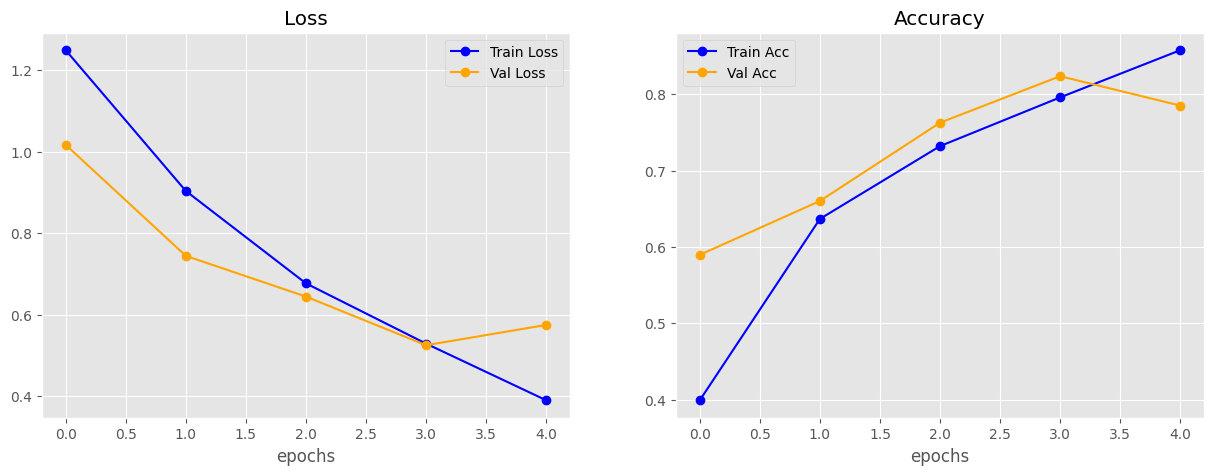

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Classification Report for <Sequential name=sequential_8, built=True>:
                  precision    recall  f1-score   support

    glioma_tumor       0.69      0.90      0.78        90
meningioma_tumor       0.84      0.54      0.66        91
          normal       0.81      0.89      0.85        44
 pituitary_tumor       0.92      0.93      0.92        84

        accuracy                           0.80       309
       macro avg       0.82      0.81      0.80       309
    weighted avg       0.81      0.80      0.79       309

Class: Glioma_Tumor
Precision: 0.686
Recall: 0.900
F1-Score: 0.779

Class: Meningioma_Tumor
Precision: 0.845
Recall: 0.538
F1-Score: 0.658

Class: Normal
Precision: 0.812
Recall: 0.886
F1-Score: 0.848

Class: Pituitary_Tumor
Precision: 0.918
Recall: 0.929
F1-Score: 0.923


Accuracy: 0.799


In [39]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load and preprocess images
def load_and_preprocess_image(img_path, img_size):
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

# Load and preprocess images
img_size = (150, 150)  # Resize images to 150x150
train_images = np.array([load_and_preprocess_image(img, img_size) for img in train_img_list])
test_images = np.array([load_and_preprocess_image(img, img_size) for img in test_img_list])
val_images = np.array([load_and_preprocess_image(img, img_size) for img in val_img_list])

# Convert labels to one-hot encoded format
label_to_index = {label: idx for idx, label in enumerate(sorted(set(train_label_list)))}
num_classes = len(label_to_index)
train_labels = to_categorical([label_to_index[label] for label in train_label_list], num_classes=num_classes)
test_labels = to_categorical([label_to_index[label] for label in test_label_list], num_classes=num_classes)
val_labels = to_categorical([label_to_index[label] for label in val_label_list], num_classes=num_classes)

# Train the model
cnn_model = create_cnn_model(input_shape=(150, 150, 3), num_classes=num_classes)
cnn_history = cnn_model.fit(train_images, train_labels, epochs=30, validation_data=(val_images, val_labels))

# Plot training curves
plot_curves(cnn_history)

# Generate confusion matrix and calculate metrics
categories = list(label_to_index.keys())
conf_matrix = CM(cnn_model, test_images, test_labels, categories)
calculate_metrics(conf_matrix, categories)